%% Cell type:markdown id:5fc6ee0e-481f-4399-9d03-c2499f5416a8 tags:
<a id="introduction"></a>
# Introduction
Voyons si nous pouvons confirmer une telle relation pour l'endettement *public*.
*NB1 : par souci de lisibilité, certaines fonctions ont été rassemblées dans des scripts et n'apparaissent pas directement dans ce notebook.*
*NB2 : les cartes sont dynamiques, mais ne s'affichent pas correctement sur gitlab.*
%% Cell type:markdown id:6f24dab8-1b5b-4806-b084-b1b210519358 tags:
<a id="sommaire"></a>
## Sommaire
- [Installation des librairies](#installation)
- [Collecte des données](#collecte)
  - [Données des évènements sportifs](#olympique)
  - [Données de dépenses](#depenses)
  - [Données "nationales"](#nationales)
- [Première agrégation de la base](#premiere)
  - [Création de variables de médailles par athlètes et de dépenses par habitant](par_habitant)
  - [Création de score olympique et paralympique](#score_olympique)
  - [Création de variables de moyenne temporelle de dépenses publiques](#moyennes)
  - [Suppression de certaines lignes et colonnes](#suppression)
- [Choix de la sélection de pays] (#sel_pays)
  - [Présentation de trois bases intéressantes] (#bases)
  - [Variance des variables] (#var)
  - [Valeurs manquantes] (#nan)
- [Statistiques descriptives] (stat_desc)
  - [Moyennes et valeurs extrêmales] (moyenne_extrem)
  - [Nuages de points] (#nuages)
  - [Matrice de corrélation] (#correlation)
- [Analyse] (#analyse)
  - [Regression linéaire entre scores olympiques] (#reg_lin)
  - [ACP entre score paralympiques et statistiques propres au pays] (#ACP)
  - [Conclusions] (#conclusions)
- [Conclusion et perspectives](#suites)


<a id="installation"></a>
## Installation des librairies

In [1]:
!pip install -r requirements.txt

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import io
import matplotlib
from PIL import Image

In [2]:
from Toutes_les_df_olympiques.df_medailles_olympiques import get_medal_table as get_medal_table_olympic
from Toutes_les_df_olympiques.df_athletes_olympiques import get_athlete_table as get_athlete_table_olympic
from Toutes_les_df_de_depenses.df_depenses_publiques import get_public_expend
from Toutes_les_df_de_depenses.df_education import get_education

       pays  or_olympique  argent_olympique  bronze_olympique  \
6    France            11                11                13   
93   France            10                18                14   
181  France            10                12                11   
272  France            16                26                22   

     total_medailles_olympiques annee  
6                            35  2012  
93                           42  2016  
181                          33  2020  
272                          64  2024  


<a id="collecte"></a>
## Collecte des données

<a id="olympique"></a>
### Données des évènements sportifs

Dans les données d'évènements sportifs, on cherche à collecter le nombre de médailles de chaque type par édition et par nation ainsi que le nombre d'athètes par nation et par édition.

Nous procédons par scrapping sur Wikipédia. Cependant, les pages Wikipédia des jeux antérieurs à 2012 n'affichent pas le nombre d'athlètes par pays. Nous nous restreindrons alors aux jeux entre 2012 et 2024. 

Les fonctions get_..._table permettent de scrapper les données, ici un exemple pour le nombre de médailles et d'athlètes aux jeux olympiques de Rio 2016.

In [3]:
url_medailles="https://en.wikipedia.org/wiki/2016_Summer_Olympics_medal_table" #Tableau des médailles des jeux olympiques de 2016

df_medailles = get_medal_table_olympic(2016,url_medailles)
u=0  #u est un compteur qui vérifie qu'on a le df tel qu'il est généré par cette cellule
df_medailles

,pays,or_olympique,argent_olympique,bronze_olympique,total_medailles_olympiques,annee
0,United States,46,37,38,121,2016
1,Great Britain,27,23,17,67,2016
2,China,26,18,26,70,2016
3,Russia‡,19,17,20,56,2016
4,Germany,17,10,15,42,2016
...,...,...,...,...,...,...
82,Nigeria,0,0,1,1,2016
83,Portugal,0,0,1,1,2016
84,Trinidad and Tobago,0,0,1,1,2016
85,United Arab Emirates,0,0,1,1,2016


In [4]:
url_athletes= "https://en.wikipedia.org/wiki/2016_Summer_Olympics" #Page Wikipedia des athlètes olympiques en 2016

df_athletes = get_athlete_table_olympic(2016,url_athletes)

df_athletes

,pays,athletes_olympiques,annee
0,United States,554,2016
1,Brazil,465,2016
2,Germany,425,2016
3,Australia,421,2016
4,China,413,2016
...,...,...,...
201,Mauritania,2,2016
202,Nauru,2,2016
203,Somalia,2,2016
204,Swaziland,2,2016


Chauvins, nous décidons d'avoir une base de données en français, on traduit les noms de pays et corrige des problèmes de typographie avec un dictionnaire (créé par Mistral AI car nous sommes chauvins).

In [5]:
from Toutes_les_df_olympiques.df_medailles_olympiques import countries_en_fr_cio

if u==0 :
    df_medailles["pays"] = (
    df_medailles["pays"].str.replace(r"[^A-Za-z ,\-']", "", regex=True).str.strip()
    )
    df_medailles["pays"] = df_medailles["pays"].map(countries_en_fr_cio)
    u=1

df_medailles.head(-1)
#la dernière ligne est un NaN car "Total"
#n'est pas dans le dictionnaire et le total de médailles ne sera pas utile par la suite

,pays,or_olympique,argent_olympique,bronze_olympique,total_medailles_olympiques,annee
0,États-Unis,46,37,38,121,2016
1,Royaume-Uni,27,23,17,67,2016
2,Chine,26,18,26,70,2016
3,Russie,19,17,20,56,2016
4,Allemagne,17,10,15,42,2016
...,...,...,...,...,...,...
81,Maroc,0,0,1,1,2016
82,Nigéria,0,0,1,1,2016
83,Portugal,0,0,1,1,2016
84,Trinité-et-Tobago,0,0,1,1,2016


<a id="depenses"></a>
### Données de dépenses

Afin d'expliquer les différences de succès paralympique, nous collectons les données de dépenses publiques dans certains secteurs :  
    - Les loisirs et le sport (construction d'équipements sportifs, subventions aux associations sportives, organisation d'évènements...). Ces dépenses paraissent très liées à la culture du sport et donc à la réussite sportive.   
    - La gestion des maladies et de l'invalidité (soins hospitaliers, construction d'hôpitaux, constructions d'équipements d'aide aux handicapés...). Il semble aussi logique que des dispositifs d'aide aux malades et aux handicapés améliorent la réussite aux jeux paralympiques. Cependant, l'immense majorité de ces dépenses va dans les soins hospitaliers ce qui rend moins évident sa contribution à la réussite paralympique.  
    - L'aménagement du territoire (construction de routes, urbanisme, aménagement de zones commerciales...). Ces dépenses limitent l'isolement des zones peu densément peuplées et peuvent détecter plus facilement les athlètes à haut potentiel.  
    - L'éducation (construction d'écoles, salaire des professeurs, financement des écoles publiques...). Cette variable est mentionnée dans cet article comme un déterminant de la réussite olympique, essayons donc de voir si ce résultat persiste au niveau paralympique.  

https://medium.com/@mmvillar/is-the-distribution-of-olympic-medals-truly-fair-378e509bf80e

Pour collecter les données de dépense en aménagement du territoire/ loisirs et sports et maladie et invalidité, on utilise l'API de Eurostat.

Chacun de ces secteurs est associé à un numéro GF.... et donne la part du PIB investie dans le secteur.

Nous n'avons accès à ces données que pour les pays européens ce qui posera problème dans le choix des pays sélectionnés dans la base de données finales.

In [6]:
from eurostat import get_data_df
from Toutes_les_df_de_depenses.df_depenses_publiques import pays_dict
from Toutes_les_df_de_depenses.df_depenses_publiques import cofog_labels


df_depenses = get_public_expend()
df_depenses['pays'] = df_depenses['pays'].map(pays_dict)
df_depenses['cofog99'] = df_depenses['cofog99'].map(cofog_labels)
df_depenses.rename(columns={'cofog99': 'type_depense'}, inplace=True)

df_depenses = df_depenses.pivot_table(
    index=['pays', 'annee'],
    columns='type_depense',
    values='depense', 
    aggfunc='first'
).reset_index()

df_depenses

type_depense,pays,annee,amenagement_territoire,loisirs_sports,maladie_invalidite
0,Allemagne,2000,0.2,0.3,2.7
1,Allemagne,2001,0.2,0.3,2.7
2,Allemagne,2002,0.2,0.3,2.8
3,Allemagne,2003,0.2,0.3,2.8
4,Allemagne,2004,0.2,0.3,2.7
...,...,...,...,...,...
688,Suède,2019,0.3,0.7,3.7
689,Suède,2020,0.3,0.7,3.8
690,Suède,2021,0.3,0.8,3.6
691,Suède,2022,0.3,0.6,3.5


Pour l'éducation, nous y avons accès depuis l'API de la World Bank Data. Ces données concernent la plupart des pays du monde.

La table comporte aussi la dépense d'éducation dans des régions du monde (Monde Arabe, Hauts revenus, Asie Centrale ...). Elles seront supprimées lors de la jointure de toutes les tables.

In [7]:
import world_bank_data
from Toutes_les_df_de_depenses.df_education import country_mapping

df_education=get_education()

df_education['pays'] = df_education['pays'].replace(country_mapping)

df_education


,pays,annee,education
0,Afrique orientale et australe,2010,4.024030
1,Afrique orientale et australe,2011,4.639015
2,Afrique orientale et australe,2012,4.676120
3,Afrique orientale et australe,2013,4.637694
4,Afrique orientale et australe,2014,4.659660
...,...,...,...
3719,Zimbabwe,2019,NaN
3720,Zimbabwe,2020,NaN
3721,Zimbabwe,2021,NaN
3722,Zimbabwe,2022,NaN


<a id="nationales"></a>
### Données "nationales"

Reste enfin les données que nous qualifierons de "nationales" : le PIB par habitant et l'IDH.

Les données sont collectées grâce à un csv et un excel. Nous n'avons pris ces variables que depuis 2008; nous nous servirons de ces variables sans faire de calculs nécessitant les années d'avant.

Par souci de lisibilité, on ne détaillera pas leur collecte qui est presque similaire à celles précédentes.

In [8]:
df_pib_par_habitant=pd.read_pickle('Toutes_les_df_nationales/df_pib_par_habitant.pkl')
df_pib_par_habitant

,pays,annee,pib_habitant
0,Aruba,2008,28171.909401
1,NaN,2008,1421.118613
2,Afghanistan,2008,381.733238
3,NaN,2008,1668.841082
4,Angola,2008,4103.066900
...,...,...,...
4516,Samoa,2024,4898.771408
4517,Kosovo,2024,7299.434981
4519,Afrique du Sud,2024,6253.371582
4520,Zambie,2024,1235.084665


Les pays avec un NaN sont les régions du monde qui ne sont transformées en NaN à la traduction du DataFrame.

Pour l'IDH on a toujours les NaN qui sont les régions du monde, on dispose de cette table :

In [9]:
df_idh=pd.read_pickle('Toutes_les_df_nationales/df_idh.pkl')
df_idh

,pays,annee,idh
0,Afghanistan,2008,0.446
1,Albanie,2008,0.749
2,Algérie,2008,0.711
3,Andorre,2008,0.864
4,Angola,2008,0.504
...,...,...,...
3234,NaN,2023,0.818
3235,NaN,2023,0.783
3236,NaN,2023,0.672
3237,NaN,2023,0.568


<a id="premiere"></a>
## Première agrégation de la base

On commence évidemment par joindre toutes les tables présentées plus tôt sur le couple (pays,annee).

In [10]:
from Toutes_les_df_olympiques.df_medailles_paralympiques import df_para as df_medailles_paralympiques
from Toutes_les_df_olympiques.df_athletes_paralympiques import df_para as df_athletes_paralympiques
from Toutes_les_df_olympiques.df_medailles_olympiques import df_medailles as df_medailles_olympiques
from Toutes_les_df_olympiques.df_athletes_olympiques import df_athletes as df_athletes_olympiques
from Toutes_les_df_de_depenses.df_depenses_publiques import df_longue as df_depenses_publiques

df_merge = df_medailles_olympiques.merge(
    df_medailles_paralympiques, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge = df_merge.merge(
    df_athletes_olympiques, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge = df_merge.merge(
    df_athletes_paralympiques, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge = df_merge.merge(
    df_depenses_publiques, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge = df_merge.merge(
    df_education, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge = df_merge.merge(
    df_idh, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge = df_merge.merge(
    df_pib_par_habitant, 
    on=['pays', 'annee'], 
    how='outer'
)

df_merge.query("pays == 'France' and annee.isin([2012,2016,2020,2024])")

,pays,or_olympique,argent_olympique,bronze_olympique,total_medailles_olympiques,annee,or_paralympique,argent_paralympique,bronze_paralympique,total_medailles_paralympiques,athletes_olympiques,athletes_paralympiques,amenagement_territoire,loisirs_sports,maladie_invalidite,education,idh,pib_habitant
1883,France,11.0,11.0,13.0,35.0,2012,8.0,19.0,18.0,45.0,324.0,158,0.7,0.6,2.7,NaN,0.893,40863.581441
1887,France,10.0,18.0,14.0,42.0,2016,9.0,5.0,14.0,28.0,399.0,126,0.6,0.5,2.8,NaN,0.905,37024.215713
1891,France,10.0,12.0,11.0,33.0,2020,11.0,15.0,29.0,55.0,398.0,137,0.6,0.5,3.1,5.65872,0.909,39169.860600
1895,France,16.0,26.0,22.0,64.0,2024,19.0,28.0,28.0,75.0,573.0,239,NaN,NaN,NaN,NaN,NaN,46150.487686


<a id="par_habitant"></a>
### Création de variables de médailles par athlètes et de dépenses par habitant

Sans ramener les variables au nombre d'athlètes, l'étude n'aurait que peu d'intérêt, on ramène donc les variables sportives au nombre d'athlètes présents et les variables de dépenses en valeur absolue par habitant.

Ici le nombre de médailles par athlète aux jeux paralympiques:

In [11]:
df_merge['athletes_olympiques'] = pd.to_numeric(df_merge['athletes_olympiques'], errors='coerce')
df_merge['athletes_paralympiques'] = pd.to_numeric(df_merge['athletes_paralympiques'], errors='coerce')
df_merge["annee"] = pd.to_numeric(df_merge["annee"], errors='coerce')

df_merge['or_paralympique_par_athlete'] = df_merge['or_paralympique'] / df_merge['athletes_paralympiques']
df_merge['argent_paralympique_par_athlete'] = df_merge['argent_paralympique'] / df_merge['athletes_paralympiques']
df_merge['bronze_paralympique_par_athlete'] = df_merge['bronze_paralympique'] / df_merge['athletes_paralympiques']
df_merge['total_medailles_paralympiques_par_athlete'] = df_merge['total_medailles_paralympiques'] / df_merge['athletes_paralympiques']

df_merge.query("pays == 'France' and annee.isin([2012,2016,2020,2024])")[['pays','annee', 'or_paralympique_par_athlete',
'argent_paralympique_par_athlete','bronze_paralympique_par_athlete','total_medailles_paralympiques_par_athlete']]

,pays,annee,or_paralympique_par_athlete,argent_paralympique_par_athlete,bronze_paralympique_par_athlete,total_medailles_paralympiques_par_athlete
1883,France,2012.0,0.050633,0.120253,0.113924,0.284810
1887,France,2016.0,0.071429,0.039683,0.111111,0.222222
1891,France,2020.0,0.080292,0.109489,0.211679,0.401460
1895,France,2024.0,0.079498,0.117155,0.117155,0.313808


Et ici les dépenses par habitant dans chaque secteur :

In [12]:
df_merge['amenagement_territoire_par_habitant'] = df_merge['amenagement_territoire'] * df_merge['pib_habitant']
df_merge['loisirs_sports_par_habitant'] = df_merge['loisirs_sports'] * df_merge['pib_habitant']
df_merge['maladie_invalidite_par_habitant'] = df_merge['maladie_invalidite'] * df_merge['pib_habitant']
df_merge['education_par_habitant'] = df_merge['education'] * df_merge['pib_habitant']

df_merge.query("pays == 'France' and annee.isin([2012,2016,2020,2024])")[['pays','annee', 'amenagement_territoire_par_habitant',
'loisirs_sports_par_habitant','maladie_invalidite_par_habitant','education_par_habitant']]

,pays,annee,amenagement_territoire_par_habitant,loisirs_sports_par_habitant,maladie_invalidite_par_habitant,education_par_habitant
1883,France,2012.0,28604.507009,24518.148865,110331.669891,NaN
1887,France,2016.0,22214.529428,18512.107857,103667.803997,NaN
1891,France,2020.0,23501.916360,19584.930300,121426.567860,221651.27422
1895,France,2024.0,NaN,NaN,NaN,NaN


<a id="score_olympique"></a>
### Création de score olympique et paralympique

Pour évaluer la performance sportive, deux variables sont immédiates : le total de médailles et le classement aux Jeux.

Cependant, le classement aux Jeux valorise trop les médailles d'or (avoir une médaille d'or et zéro médailles d'argent nous place devant un pays avec zéro médailles d'or et dix d'argent) et le total de médailles pas assez.

Nous créons donc un score olympique et paralympique rapportant trois points par médaille d'or, deux par médaille d'argent, un par médaille de bronze le tout ramené au nombre d'athlètes.

Ici la table pour le score paralympique en 2016 :

In [13]:
df_merge['score_paralympique'] = (3 * df_merge['or_paralympique_par_athlete'] + 
                                 2 * df_merge['argent_paralympique_par_athlete'] + 
                                 df_merge['bronze_paralympique_par_athlete'])

df_merge.query("annee==2016")[['pays','annee','score_paralympique','total_medailles_paralympiques_par_athlete']].sort_values(by='score_paralympique', ascending=False) \
        .head(10)

,pays,annee,score_paralympique,total_medailles_paralympiques_par_athlete
3528,Ouganda,2016.0,2.000000,1.000000
5027,Trinité-et-Tobago,2016.0,2.000000,1.000000
1178,Chine,2016.0,1.733766,0.775974
3545,Ouzbékistan,2016.0,1.656250,0.968750
736,Bahreïn,2016.0,1.500000,0.500000
1436,Cuba,2016.0,1.454545,0.681818
3477,Nouvelle-Zélande,2016.0,1.419355,0.677419
5112,Ukraine,2016.0,1.404762,0.696429
4015,Qatar,2016.0,1.333333,0.666667
862,Biélorussie,2016.0,1.300000,0.500000


Ne raisonner que par le score va poser un problème : surreprésenter les pays ayant un athlète exceptionnel mais aucun autre athlète disputant les Jeux. L'Ouganda montre ce problème. Il faudra en prendre compte lors de la sélection des pays.

<a id="moyennes"></a>
### Création d'une moyenne depuis 2008 pour chaque dépense publique

Le problème de considérer une dépense publique à un instant t est qu'un pays bénéficie généralement des investissements faits précédemment. On utilisera donc plutôt des variables de moyenne des dépenses publiques depuis 2008.

De plus, cette méthode réduit le nombre de NaN. Par exemple, il n'y a pas de valeur d'éducation de la France en 2024 mais bien une valeur de moyenne d'éducation.

In [14]:
from Toutes_les_df_agregees.fonction_moyenne import creation_moyenne

creation_moyenne(df_merge)

u_2=0 #Sert à pouvoir rééxécuter la cellule suivante
df_merge.query("pays == 'France' and annee==2024")[['pays','annee','moy_amenagement_2008','moy_loisirs_2008',
'moy_maladie_2008','moy_education_2008']]

,pays,annee,moy_amenagement_2008,moy_loisirs_2008,moy_maladie_2008,moy_education_2008
1895,France,2024.0,27759.0728,23039.075135,114870.896502,221707.363482


<a id="suppression"></a>
### Suppression de certaines lignes et colonnes

N disposons désormais d'une base de données avec de nombreuses colonnes et observations. Cependant, il convient de restreindre nos observations et nos variables. 

On supprime donc les variables non ramenées au nombre d'athlètes / habitants, cela n'a pas vraiment de sens de comparer ces variables entre les pays.

On supprime aussi les pays n'ayant jamais ramené un seul athlète aux Jeux Olympiques notamment pour enlever les régions (Afrique du Nord, Haut Revenu etc...) issues de la collecte des données.

On garde cependant les années non olympiques et les variables à un instant t qui seront utiles aux statistiques descriptives.

In [15]:
if u_2==0:
    #Suppression des pays n'ayant jamais amené d'athlètes aux jeux olympiques (permet surtout d'enlever les groupes de pays présents dans certaines bases : Afrique du Nord, etc...)
    df_merge = df_merge[df_merge.groupby('pays')['athletes_olympiques'].transform('sum') > 0]

    #Suppression des variables non ramenées au nombre d'athlètes/habitants
    df_merge = df_merge.drop('or_olympique', axis=1)
    df_merge = df_merge.drop('argent_olympique', axis=1)
    df_merge = df_merge.drop('bronze_olympique', axis=1)
    df_merge = df_merge.drop('total_medailles_olympiques', axis=1)
    df_merge = df_merge.drop('or_paralympique', axis=1)
    df_merge = df_merge.drop('argent_paralympique', axis=1)
    df_merge = df_merge.drop('bronze_paralympique', axis=1)
    df_merge = df_merge.drop('total_medailles_paralympiques', axis=1)
    df_merge = df_merge.drop('amenagement_territoire', axis=1)
    df_merge = df_merge.drop('maladie_invalidite', axis=1)
    df_merge = df_merge.drop('loisirs_sports', axis=1)
    df_merge = df_merge.drop('education', axis=1)

df_merge.query("pays == 'France' and annee == 2020") #NB Dans ce notebook, on n'a pas créé la variable de score olympique, mais elle est bien dans le code

,pays,annee,athletes_olympiques,athletes_paralympiques,idh,pib_habitant,or_paralympique_par_athlete,argent_paralympique_par_athlete,bronze_paralympique_par_athlete,total_medailles_paralympiques_par_athlete,amenagement_territoire_par_habitant,loisirs_sports_par_habitant,maladie_invalidite_par_habitant,education_par_habitant,score_paralympique,moy_education_2008,moy_loisirs_2008,moy_amenagement_2008,moy_maladie_2008
1891,France,2020.0,398.0,137.0,0.909,39169.8606,0.080292,0.109489,0.211679,0.40146,23501.91636,19584.9303,121426.56786,221651.27422,0.671533,217658.521862,22976.122834,27491.456041,111776.827818


<a id="sel_pays"></a>
## Quels pays sélectionner pour l'analyse ?

Nous avons désormais une base très grande, utilisons des statistiques descriptives pour déterminer quels pays nous permettrons de faire l'analyse la plus pertinente.

<a id="bases"></a>
### Le problème de table avec tous les pays : la variance des variables explicatives

Si la table df_tous_pays contient plusieurs milliers d'observations, il reste un problème important. Les variables explicatives (PIB par habitant, IDH, dépenses par habitant) sont extrêmement variables.

Regardons le coefficient de variation, nommé ici Quotient, de cette table.

In [27]:
from statistiques_descriptives.Stat_descr import quotient

df_tous_pays=pd.read_pickle("Toutes_les_df_agregees/df_tous_pays.pkl")

df_quotient_tous_pays=quotient(df_tous_pays,df_tous_pays)

df_quotient_tous_pays

,Variable,Moyenne,Quotient (%),Observations
0,total_medailles_olympiques_par_athlete,0.103038,74.816645,357
1,total_medailles_paralympiques_par_athlete,0.349923,57.916799,328
2,moy_amenagement_2008,7889.104386,111.846878,104
3,moy_maladie_2008,97492.726820,89.940841,104
4,moy_loisirs_2008,13512.757851,84.672868,104
5,moy_education_2008,76958.713671,146.834144,628
6,pib_habitant,17783.190239,155.304385,3119
7,idh,0.718348,21.451897,3064


Il est inadmissible d'utiliser une base dont l'écart-type de certaines variables est supérieur à leur moyenne.

On essaie donc de prendre les dix pays les plus riches (en terme de PIB par habitant) pour avoir a priori des variables un peu moins volatiles. On fait aussi attention à ne sélectionner des pays ayant amené au moins cinq athlètes en moyenne au cours des quatre précédents jeux paralympiques.

On observe ensuite leur Quotient de variation défini comme l'écart-type sur la table divisé par la moyenne de df_tous_pays.

In [28]:
df_top_10=pd.read_pickle('Toutes_les_df_agregees/df_top_10.pkl')

pays = df_top_10['pays'].unique()
print(f"Les pays de cette nouvelle table sont : \n{', '.join(pays)}")

df_cv_top_10=quotient(df_top_10,df_tous_pays)

df_cv_top_10

Les pays de cette nouvelle table sont : 
Australie, Danemark, Irlande, Islande, Norvège, Pays-Bas, Singapour, Suisse, Suède, États-Unis


,Variable,Moyenne,Quotient (%),Observations
0,total_medailles_olympiques_par_athlete,0.093922,47.036974,35
1,total_medailles_paralympiques_par_athlete,0.370660,48.695311,37
2,moy_amenagement_2008,7989.719225,68.723454,16
3,moy_maladie_2008,240282.551695,59.338951,16
4,moy_loisirs_2008,24633.244311,73.923415,16
5,moy_education_2008,372972.166098,175.068831,36
6,pib_habitant,66199.947643,91.922149,170
7,idh,0.942431,2.189008,160


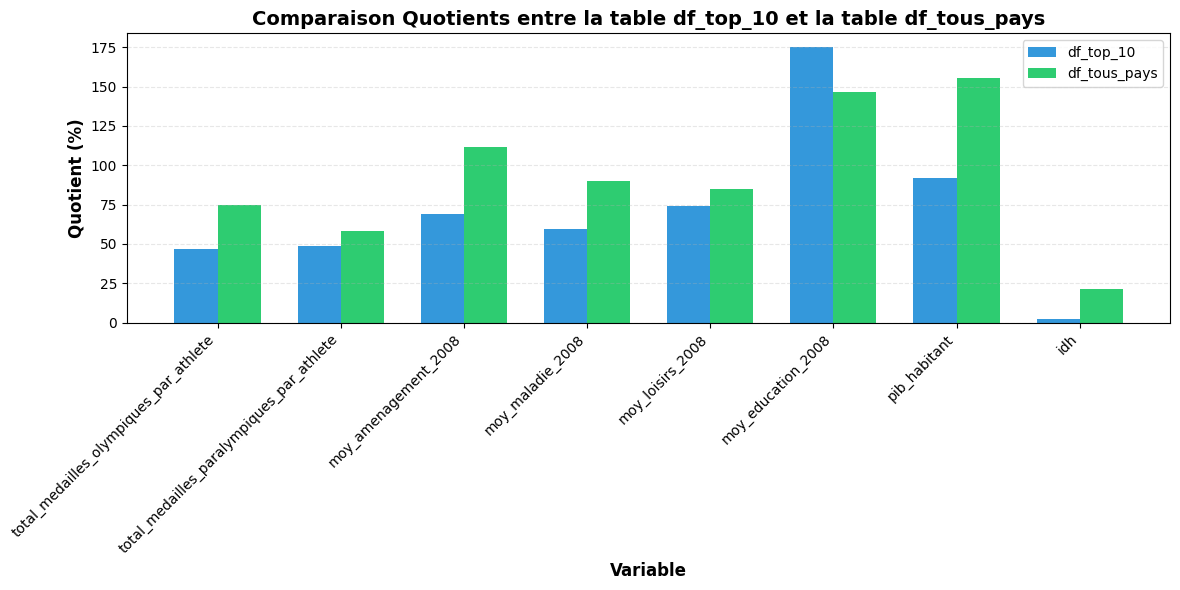

In [35]:
variables = df_cv_top_10['Variable'].values
cv_top10 = df_cv_top_10['Quotient (%)'].values
cv_tous_pays = df_cv_tous_pays[df_cv_tous_pays['Variable'].isin(variables)]['Quotient (%)'].values

#Créer le graphique
x = np.arange(len(variables))
largeur = 0.35
fig, ax = plt.subplots(figsize=(12, 6))
barres1 = ax.bar(x - largeur/2, cv_top10, largeur, label='df_top_10', color='#3498db')
barres2 = ax.bar(x + largeur/2, cv_tous_pays, largeur, label='df_tous_pays', color='#2ecc71')

#Legende
ax.set_xlabel('Variable', fontsize=12, fontweight='bold')
ax.set_ylabel('Quotient (%)', fontsize=12, fontweight='bold')
ax.set_title('Comparaison Quotients entre la table df_top_10 et la table df_tous_pays', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(variables, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Cette sélection présente des résultats encourageants, tous les quotients ont diminué à l'exception de moyenne éducation qui a augmenté. Néanmoins, ils restent très importants et proches de 100. 
De plus, un autre problème va nous empêcher d'utiliser cette table.

<a id="nan"></a>
### Valeurs manquantes, la table df_top_10 devient inutilisable

Le problème de cette table, c'est que comme la plupart de ses pays sont non européens, les données de dépenses publiques en aménagement du territoire, santé et loisirs sont inaccessibles.

Calculons le pourcentage de valeurs manquantes de cette table (en ne conservant que les années olympiques) :

In [36]:
from statistiques_descriptives.valeurs_manquantes import pourcentage_valeurs_manquantes

pourcentage_valeurs_manquantes(df_top_10)

,Variable,Pourcentage de valeurs manquantes
0,moy_maladie_2008,60.0
1,moy_amenagement_2008,60.0
2,moy_loisirs_2008,60.0
3,moy_education_2008,10.0
4,score_paralympique,7.5
5,score_olympique,12.5
6,pib_habitant,0.0
7,idh,25.0


Et en comparant à df_tous_pays, on voit que le quotient est plus faible pour toutes les variables sauf la moyenne d'éducation.

<a id="bases"></a>
### La table idéale

60% de valeurs manquantes pour des variables explicatives, c'est beaucoup trop.

Voici alors une dernière table construite telle que : 
- On ne conserve que les pays ayant moins de 5 NaN entre 2008 et 2023
- On ne conserve que les pays ayant ramené en moyenne plus de cinq athlètes par jeux paralympiques 
- On prend les 10 au plus haut PIB par habitant

In [39]:
df_top_10_sans_NaN=pd.read_pickle('Toutes_les_df_agregees/df_top_10_sans_NaN.pkl')

pays = df_top_10_sans_NaN['pays'].unique()
print(f"Les pays de cette nouvelle table sont : \n{', '.join(pays)}")

df_stats=quotient(df_top_10_sans_NaN,df_tous_pays)
df_nan=pourcentage_valeurs_manquantes(df_top_10_sans_NaN)
df_complet = df_nan.merge(df_stats, on='Variable', how='outer')
df_complet = df_complet.fillna('/') #Les NaN ici seront juste les variables qui ne sont présentes que dans df_stats ou que dans df_nan

df_complet

Les pays de cette nouvelle table sont : 
Allemagne, Autriche, Belgique, Danemark, Finlande, France, Irlande, Italie, Pays-Bas, Suède


,Variable,Pourcentage de valeurs manquantes,Moyenne,Quotient (%),Observations
0,idh,25.0,0.928744,2.872093,160.0
1,moy_amenagement_2008,0.0,9628.052441,102.539084,40.0
2,moy_education_2008,5.0,295649.622192,119.737368,38.0
3,moy_loisirs_2008,0.0,20021.665202,63.070577,40.0
4,moy_maladie_2008,0.0,169095.343365,78.353436,40.0
5,pib_habitant,0.0,51606.477681,70.60631,170.0
6,score_olympique,5.0,/,/,/
7,score_paralympique,0.0,/,/,/
8,total_medailles_olympiques_par_athlete,/,0.079586,30.750664,38.0
9,total_medailles_paralympiques_par_athlete,/,0.336557,43.221863,40.0


En voilà des résultats satisfaisants, hormis l'IDH nous n'avons presque aucun NaN dans les variables explicatives. De plus, nous avons une quarantaine de couples (pays,année) lors des années olympiques ce qui est à peu près acceptable pour l'analyse.

 Les quotients restent de plus comparables à ceux de la table précédente, voirent diminuent :

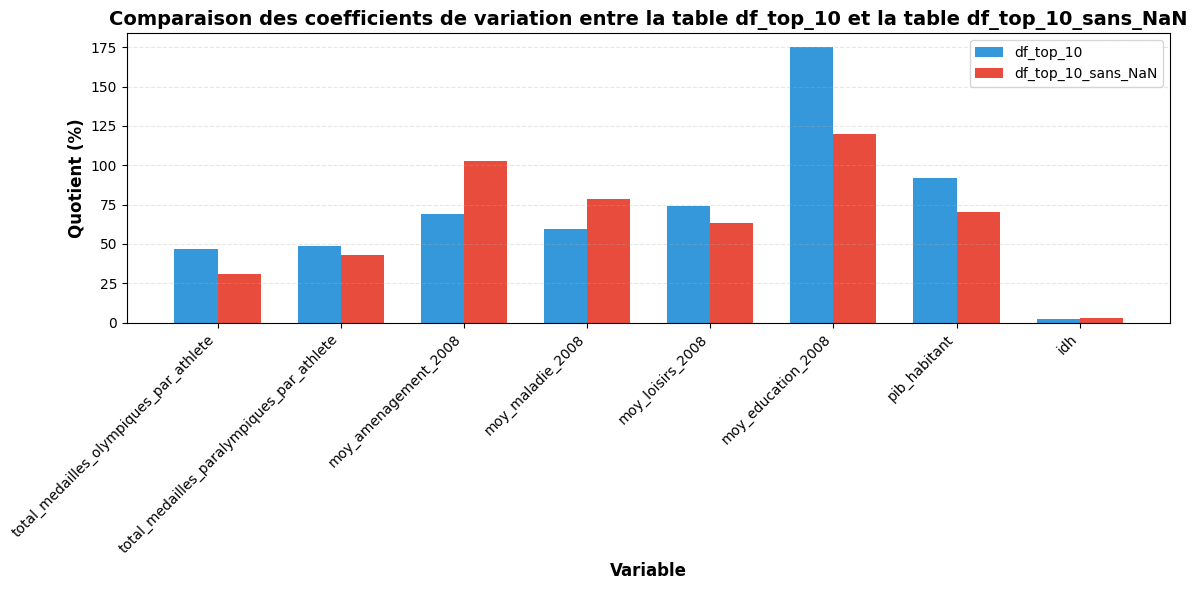

In [46]:
variables = df_cv_top_10['Variable'].values
cv_top10 = df_cv_top_10['Quotient (%)'].values
cv_stats = df_stats[df_stats['Variable'].isin(variables)]['Quotient (%)'].values

#Créer le graphique
x = np.arange(len(variables))
largeur = 0.35
fig, ax = plt.subplots(figsize=(12, 6))
barres1 = ax.bar(x - largeur/2, cv_top10, largeur, label='df_top_10', color='#3498db')
barres2 = ax.bar(x + largeur/2, cv_stats, largeur, label='df_top_10_sans_NaN', color='#e74c3c')

#Legende
ax.set_xlabel('Variable', fontsize=12, fontweight='bold')
ax.set_ylabel('Quotient (%)', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des coefficients de variation entre la table df_top_10 et la table df_top_10_sans_NaN', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(variables, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Pour résumer, nous analyserons le lien entre réussite paralympique et caractéristiques nationales uniquement sur les dix pays européens les plus riches ayant amené un nombre convenable d'athlètes aux jeux.

In [47]:
df=df_top_10_sans_NaN

<a id="stat_desc"></a>
## Statistiques descriptives

Avant l'analyse des données, observons le comportement des variables. Le tracé de l'évolution temporelle de certaines variables nous permettra de définir le champ de l'étude différemment. Puis des nuages de points et une matrice de corrélation entre statistiques explicatives et à expliquer nous donneront un aperçu de l'analyse.

<a id="evolution"></a>
### Evolution temporelle des variables

Tout d'abord, traçons l'évolution de l'IDH au fil des années :

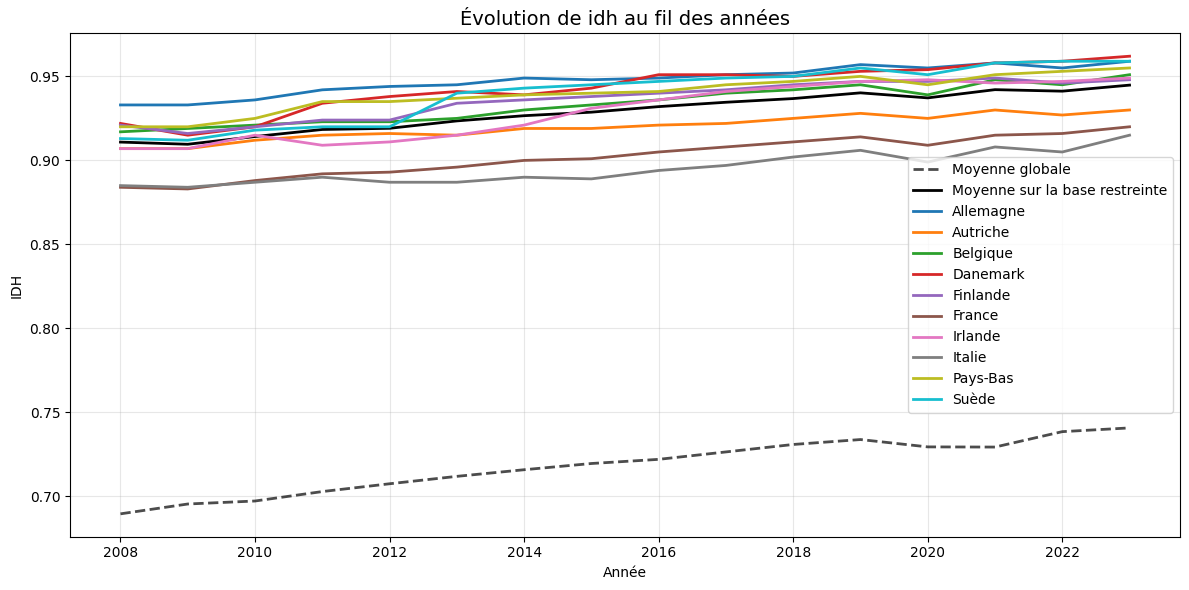

In [48]:
from statistiques_descriptives.evolution import plot_evolution


plot_evolution(df,'idh',(df['pays'].unique()),nom_axe = 'IDH', moyenne=True, df_all=df_tous_pays)

On voit que la variation d'IDH entre les pays est de moins de 0.1. De plus, tous les IDH ont une croissance similaire. Dans tous les cas, ces IDH sont très proches comparés à la moyenne mondiale (ici en pointillés). Il sera alors très difficile d'observer précisément toute corrélation concernant l'IDH.

Pour le PIB par habitant, le graphique suivant montre que tous les pays sélectionnés sont bien plus riches que la moyenne. Ce qui est normal compte-tenu de la construction de la base. Le PIB par habitant varie cependant plus entre les pays que l'IDH avec notamment l'Irlande qui est loin devant le reste de la base.

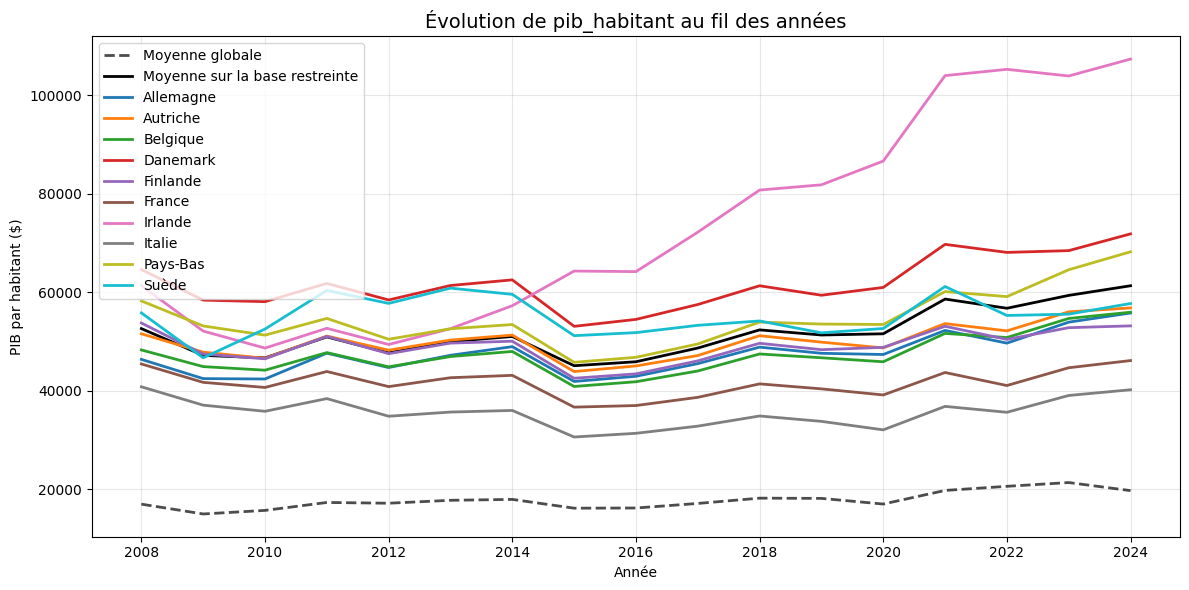

In [49]:
plot_evolution(df,'pib_habitant',(df['pays'].unique()),nom_axe = 'PIB par habitant ($)', moyenne=True, df_all=df_tous_pays)

Observons maintenant les variables de dépense par habitant :

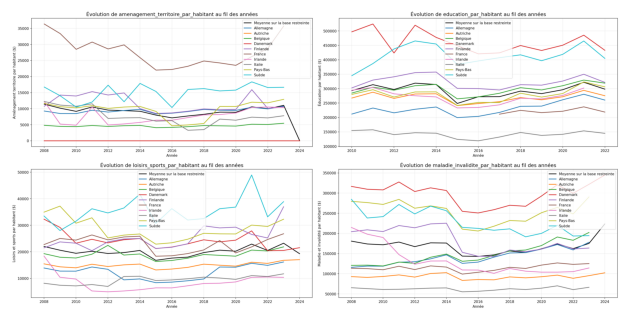

In [50]:
from statistiques_descriptives.combinaison_images import combiner_images

plot_evolution(df, 'amenagement_territoire_par_habitant', list(df['pays'].unique()), 'Aménagement territoire par habitant ($)', True,filepath='images/amenagement')
plot_evolution(df, 'loisirs_sports_par_habitant', list(df['pays'].unique()), 'Loisirs et sports par habitant ($)', True,filepath='images/loisirs')
plot_evolution(df, 'maladie_invalidite_par_habitant', list(df['pays'].unique()), 'Maladie et invalidité par habitant ($)', True,filepath='images/maladie')
plot_evolution(df, 'education_par_habitant', list(df['pays'].unique()), 'Éducation par habitant ($)', True,filepath='images/education')

combiner_images('images')

Il n'est pas nécessaire d'observer la figure en détail pour voir que excepté pour l'éducation, les variables ont des dynamiques très différentes entre les pays. A priori, ce seront pour ces variables que les résultats seront les plus précis.

Enfin, on peut observer les résultats paralympiques entre les pays selon les années.

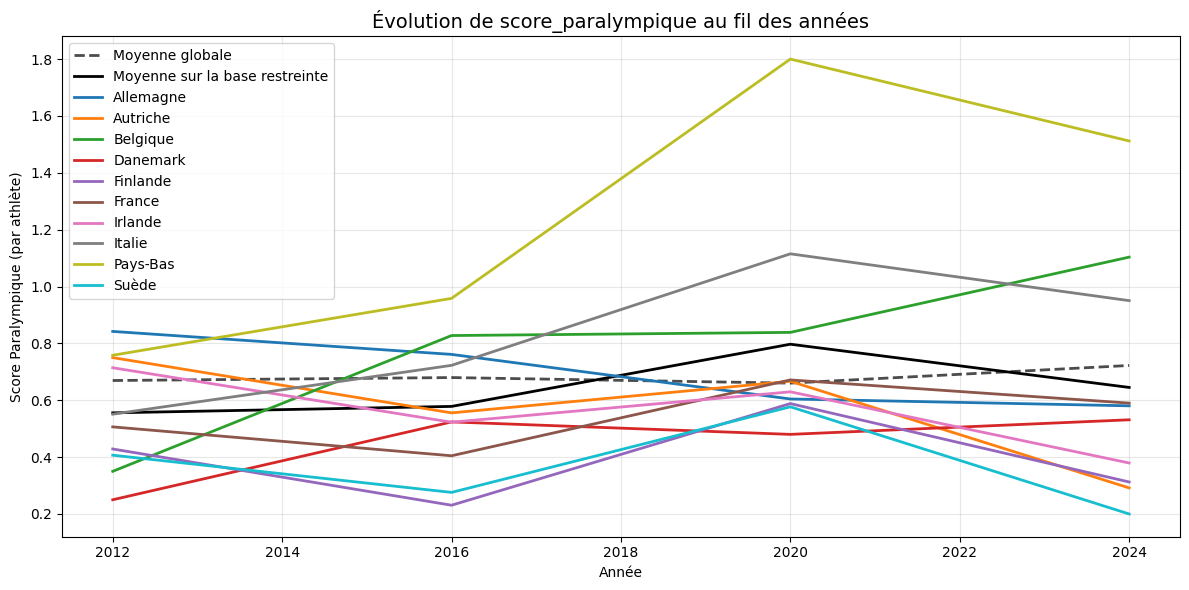

In [51]:
plot_evolution(df,'score_paralympique',(df['pays'].unique()),nom_axe = 'Score Paralympique (par athlète)', moyenne=True, df_all=df_tous_pays)

Le score olympique varie énormément entre les pays. On y distingue trois dynamiques : 
- Les pays ayant perdu en score en 2016 puis étant remonté en 2020 pour redescendre (Suède, Finlande, Autriche...) 
- Les pays n'ayant fait globalement que monter légèrement leur score depuis 2012 (Italie, Belgique, Danemark...) 
- les Pays-Bas qui se sont remarquablement éloignés de la masse depuis 2020

On voit de plus que les pays de la base ne sont pas spécialement plus performants que le reste du monde en voyant l'écart par rapport à la moyenne globale.

<a id="nuages"></a>
### Nuages de points

Ayant vu que c'est surtout les dépenses publiques par habitant qui varient d'un pays à l'autre, regardons si les nuages de points entre score_paralympique et dépenses publiques peuvent présager de bons résultats dans la partie "Analyse".

Désormais, et pour toute la suite, quand on parlera de dépense, on ne parlera que des dépenses publiques moyennes par habitant depuis 2008.

- [Statistiques descriptives] (stat_desc)
  - [Moyennes et valeurs extrêmales] (moyenne_extrem)
  - [Nuages de points] (#nuages)
  - [Matrice de corrélation] (#correlation)